# DNN convolution layer with RELU activations. FWD & BWD. GPU trace.

__Image size (HW) set to 32__

Run on Mouse

```
2Jul1247peter@mouse:~/DNNMark$ python run_series.py
Logdir logs/dnnmark_gpu_traces_with_relu/
Have 160 tasks
checking GPU 0....Starting
./run_dnnmark.sh -n 10 -k 32 -w 32 -h 32 -b test_fwd_composed_model --relu --debug
11335
1/160 tasks
checking GPU 0....Starting
nvprof -u s --profile-api-trace none --unified-memory-profiling off --profile-child-processes --print-gpu-trace --csv --log-file logs/dnnmark_gpu_traces_with_relu/dnn_test_fwd_composed_model_conv32_bs10_%p.nvprof ./run_dnnmark.sh -n 10 -k 32 -w 32 -h 32 -b test_fwd_composed_model --relu --debug
...
```

Log files
```
peter@mouse:~/DNNMark/logs/dnnmark_gpu_traces_with_relu/

dnn_test_bwd_composed_model_conv128_bs100.log           - DNNMark stdout + stderr (parse for run time)
dnn_test_bwd_composed_model_conv128_bs100.log.nvsmi     - nvidia-smi memory usage data
dnn_test_bwd_composed_model_conv128_bs100_%p.nvprof     - DNNMark stdout (not used)
dnn_test_bwd_composed_model_conv128_bs100_14661.nvprof  - profiling data (kernels)
...
```

## Read .log files

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import lib
import seaborn as sns
import itertools
from cycler import cycler
from random import randint
import math

In [2]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [3]:
batch_conv_pattern = re.compile(r"b\s*(\d+)\s+conv\s*([0-9\.]+)")
output_pattern = re.compile(r"Total running time\(ms\): ([0-9\.\e\+]+)")
#filename_pattern=re.compile(r"^dnn_bwd_conv_conv([0-9]+)_bs([0-9]+)\.log$")
filename_pattern=re.compile(r"^dnn_test_([fbwd]+)_composed_model_conv([0-9]+)_bs([0-9]+)\.log$") 

pars = {
    "batch_conv_pattern": batch_conv_pattern,
    "output_pattern" : output_pattern,
    "filename_pattern" : filename_pattern,
    "columns" : ["f/b","conv","batch"]
}

In [4]:
logdir="logs/dnnmark_gpu_traces_with_relu"
dflog = lib.lib.readLogs(logdir,pars,debug=False)
print dflog.shape
dflog.head()

(80, 4)


,f/b,conv,batch,time
0,bwd,128,10,0.66626
1,bwd,128,100,4.86206
2,bwd,128,120,5.79590
3,bwd,128,140,6.75122
4,bwd,128,20,1.16309


In [5]:
dflog[["batch","conv"]] = dflog[["batch","conv"]].astype(np.int)
# Convert ms to s
dflog["time"] = dflog["time"]/1000
dflog.sort_values(by=["batch","conv"],inplace=True)
dflog.reset_index(drop=True,inplace=True)
dflog.head()

,f/b,conv,batch,time
0,bwd,32,10,0.000375
1,fwd,32,10,0.000151
2,bwd,64,10,0.000472
3,fwd,64,10,0.000222
4,bwd,128,10,0.000666


## Read .nvsmi files

In [6]:
filename_pattern = re.compile(r"^dnn_test_([fbwd]+)_composed_model_conv(\d+)_bs(\d+)\.log\.nvsmi$")
columns = ["f/b","conv","batch"]

def readNVSMIfiles(logdir,pars):
    filename_pattern = pars["filename_pattern"]
    fix_columns = pars["columns"]
    list_command = "ls -1 "+logdir
    nvsmi_files=[]
    proc = subprocess.Popen(list_command.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        line = line.strip(" \n")
        m = filename_pattern.match(line)
        if m:
            nvsmi_files.append(os.path.abspath(os.path.join(logdir,line)))
#         else:
#             print line,"didnt match pattern",filename_pattern.pattern
    print "Found nvsmi files:",len(nvsmi_files)
    
    columns=["time","GPU","Memory Total (MiB)","Memory Used (MiB)"] + fix_columns
    df_nvsmi = pd.DataFrame(data=None,columns=columns)
    ind = 0 # DataFrame row numebr (index)
    for lf in nvsmi_files:
        logfile = lf.strip(" \n")
        df = pd.read_csv(logfile,names=columns)
        df["Memory Used (MiB)"] = df["Memory Used (MiB)"].astype(np.int)
        # Get MAX from Memory Used values, leave only one row
        df.sort_values(by="Memory Used (MiB)",inplace=True,ascending=False)
        df.reset_index(drop=True,inplace=True)
        df = df.iloc[:1]
        bs = 0
        conv = 0
        bf = ""
        filename = os.path.basename(logfile)
        m = filename_pattern.match(filename)
        if m:
            for i in range(len(fix_columns)):
                df[fix_columns[i]] = m.group(i+1)
            
        else:
            print "no match in ",filename
        if df.shape[0] > 0:
            df_nvsmi = pd.concat([df_nvsmi,df])
    df_nvsmi.reset_index(drop=True,inplace=True)
    df_nvsmi.drop(["time","GPU"],axis=1,inplace=True)
    try:
        df_nvsmi[["batch","conv","Memory Total (MiB)", "Memory Used (MiB)"]] = df_nvsmi[["batch","conv","Memory Total (MiB)", "Memory Used (MiB)"]].astype(np.int)
    except Exception as e:
        print e.message
    df_nvsmi.sort_values(by=["batch","conv"],inplace=True,ascending=True)
    df_nvsmi.reset_index(drop=True,inplace=True)
    return df_nvsmi

pars = {"columns":columns,
        "filename_pattern":filename_pattern }
df_nvsmi = readNVSMIfiles(logdir,pars)
print df_nvsmi.shape
df_nvsmi.head()

Found nvsmi files: 80
(80, 5)


,Memory Total (MiB),Memory Used (MiB),f/b,conv,batch
0,5058,610,bwd,32,10
1,5058,610,fwd,32,10
2,5058,616,bwd,64,10
3,5058,616,fwd,64,10
4,5058,620,bwd,128,10


## Merge nvsmi with log data

In [7]:
dfmerg = pd.merge(dflog,df_nvsmi,on=["batch","conv","f/b"],how='inner')
dfmerg.sort_values(by=["batch","conv"],ascending=True,inplace=True)
dfmemF = dfmerg[dfmerg["f/b"]=="fwd"].pivot(index="batch",columns="conv",values="Memory Used (MiB)")
dfmemF["Memory Total(MiB)"] = dfmerg.loc[0,"Memory Total (MiB)"]
dfmemB = dfmerg[dfmerg["f/b"]=="bwd"].pivot(index="batch",columns="conv",values="Memory Used (MiB)")
dfmemB["Memory Total(MiB)"] = dfmerg.loc[0,"Memory Total (MiB)"]
dfmemF.head()

conv,32,64,128,256,512,Memory Total(MiB)
batch,,,,,,
10,610,616,620,626,652,5058
20,614,620,628,642,724,5058
40,620,630,646,726,870,5058
60,624,638,696,744,1006,5058
80,628,646,728,870,1150,5058


## Plot times and memory

In [8]:
dfconvsF = dflog[dflog["f/b"]=="fwd"].pivot(columns="conv",index="batch",values="time")
dfconvsB = dflog[dflog["f/b"]=="bwd"].pivot(columns="conv",index="batch",values="time")
dfconvsF.head()

conv,32,64,128,256,512
batch,,,,,
10,0.000151,0.000222,0.000365,0.000632,0.001087
20,0.000226,0.000350,0.000610,0.001095,0.002095
40,0.000343,0.000660,0.001084,0.002083,0.003938
60,0.000463,0.000845,0.001664,0.003059,0.005915
80,0.000593,0.001194,0.002041,0.004050,0.007783


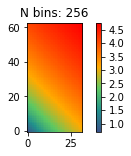

In [74]:
def getColorList(cmap,n):
    cmap = cm.get_cmap(cmap, n)
    colors = []
    for i in range(cmap.N):
        c = matplotlib.colors.to_hex(cmap(i),keep_alpha=True)
        colors.append(c)
    return colors

colors1 = getColorList("viridis",5)
colors2 = getColorList("autumn_r",4)
colors = colors1[1:-1] + colors2[1:]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=256)
lib.plotter.testColorMap(cmap)
plt.rc('axes', prop_cycle=(cycler('color', colors)))

In [75]:
from matplotlib.ticker import MultipleLocator

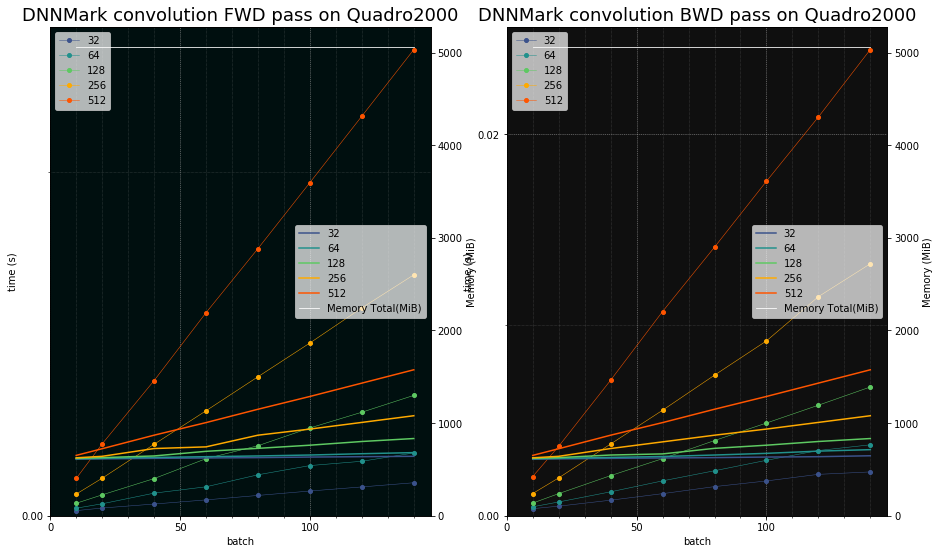

In [76]:
fig,ax = plt.subplots(1,2,figsize=(15,9))
dfconvsF.plot(lw=0.5,marker="o",ms=4,alpha=1,fillstyle="full",ax=ax[0])
ax[0].set_title("DNNMark convolution FWD pass on Quadro2000",fontsize=18)
ax1 = ax[0].twinx()
dfmemF.iloc[:,:-1].plot(lw=1.5,ax=ax1)
dfmemF.iloc[:,-1].plot(lw=.8,ax=ax1,c="w")
ax1.set_ylim(0,None)
ax[0].set_ylim(0,None)

dfconvsB.plot(lw=0.5,marker="o",ms=4,alpha=1,fillstyle="full",ax=ax[1])
ax[1].set_title("DNNMark convolution BWD pass on Quadro2000",fontsize=18)
ax2 = ax[1].twinx()
dfmemB.iloc[:,:-1].plot(lw=1.5,ax=ax2)
dfmemB.iloc[:,-1].plot(lw=.8,ax=ax2,c="w")
ax2.set_ylim(0,None)



def gridAndLabel(ax,ax1):
    ax.grid(ls=":",alpha=.6)
    ax.set_ylabel("time (s)")
    ax.set_xlim(0,None)
    ax.set_ylim(0,None)
    minorLocatorX = MultipleLocator(10)    
    majorLocatorX = MultipleLocator(50)
    minorLocatorY = MultipleLocator(0.01)
    majorLocatorY = MultipleLocator(0.02)
    ax.xaxis.set_major_locator(majorLocatorX)
    ax.xaxis.set_minor_locator(minorLocatorX)
    ax.yaxis.set_minor_locator(minorLocatorY)
    ax.yaxis.set_major_locator(majorLocatorY)
    ax.grid(which='minor', linestyle=':', linewidth=.5, alpha=.5)
    ax.legend(framealpha=.7)
    ax1.set_ylabel("Memory (MiB)")
    ax1.legend(framealpha=.7,loc='center right')
    
gridAndLabel(ax[0],ax1)
gridAndLabel(ax[1],ax2)
ax[0].set_facecolor("#000f0f")
ax[1].set_facecolor("#0f0f0f")

## Read nvprof files

In [12]:
# batch_sizes - list of valid batch sizes to read.
# Though target program may have crashed, nvprof file will still be created and have some information,
# but we don't want to see it.
def read_nvprofs(logdir,filename_pattern,batch_sizes):
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        line = line.strip(" \n")
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))

    print "Have",len(files),"files"
    nvprof  = None
    for fl in files:
        fname = os.path.basename(fl)
        m = filename_pattern.match(fname)
        conv = 0
        batch = 0
        fb = ""
        if m:
            fb = m.group(1)
            conv  = m.group(2)
            batch = m.group(3)
            #print fname,"conv=",conv,"batch=",batch
        else:
            print "not matched:",fname
            break
            
        # Check if batch in the list of batch_sizes to read
        try:
            batch = int(batch)
            conv = int(conv)
        except:
            print "Not parsable bs {} or conv size from file name {}".format(batch, conv, fname)
            
        valid_bs = batch_sizes[conv]
        if batch not in valid_bs:
            #print "-{}/{}".format(batch,conv),
            continue
        
        try:
            nvprof1 = pd.read_csv(fl, header=[0,1], skiprows=[0,1,2])
        except:
            continue
        if len(nvprof1.index) < 1:
            continue
        nvprof1["batch"] = batch
        nvprof1["conv"] = conv
        nvprof1["f/b"] = fb
        if nvprof is None:
            nvprof = nvprof1
        else:
            nvprof = pd.concat([nvprof,nvprof1])
    
    print nvprof.shape
    return nvprof

In [13]:
batch_sizes = {}
for conv in list(dflog["conv"].unique()):
    df_ = dflog[dflog["conv"] == conv]
    batch_sizes[conv] = list(df_["batch"].unique())
print batch_sizes
print logdir
print filename_pattern.pattern

{32: [10, 20, 40, 60, 80, 100, 120, 140], 64: [10, 20, 40, 60, 80, 100, 120, 140], 128: [10, 20, 40, 60, 80, 100, 120, 140], 256: [10, 20, 40, 60, 80, 100, 120, 140], 512: [10, 20, 40, 60, 80, 100, 120, 140]}
logs/dnnmark_gpu_traces_with_relu
^dnn_test_([fbwd]+)_composed_model_conv(\d+)_bs(\d+)\.log\.nvsmi$


In [14]:
filename_pattern=re.compile(r"dnn_test_([fbwd]+)_composed_model_conv(\d+)_bs(\d+)_\d+\.nvprof")
nvprof = read_nvprofs(logdir, filename_pattern, batch_sizes)
nvprof.head()

Have 80 files
(1200, 22)


,Start,Duration,Grid X,Grid Y,Grid Z,Block X,Block Y,Block Z,Registers Per Thread,Static SMem,...,Throughput,SrcMemType,DstMemType,Device,Context,Stream,Name,batch,conv,f/b
,s,s,Unnamed: 2_level_1,Unnamed: 3_level_1,Unnamed: 4_level_1,Unnamed: 5_level_1,Unnamed: 6_level_1,Unnamed: 7_level_1,Unnamed: 8_level_1,KB,...,GB/s,Unnamed: 13_level_1,Unnamed: 14_level_1,Unnamed: 15_level_1,Unnamed: 16_level_1,Unnamed: 17_level_1,Unnamed: 18_level_1,,,
0,0.923712,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.490116,Device,NaN,Quadro P2000 (0),1,22,[CUDA memset],100,128,bwd
1,0.924383,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.125370,Pageable,Device,Quadro P2000 (0),1,7,[CUDA memcpy HtoD],100,128,bwd
2,0.924766,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.719365,Device,NaN,Quadro P2000 (0),1,31,[CUDA memset],100,128,bwd
3,0.924795,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.171559,Pageable,Device,Quadro P2000 (0),1,7,[CUDA memcpy HtoD],100,128,bwd
4,0.925113,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.719365,Device,NaN,Quadro P2000 (0),1,40,[CUDA memset],100,128,bwd


In [15]:
def mergeColumnNames(col):
    if re.search("Unnamed",col[1], re.IGNORECASE):
        return col[0]
    if len(col[1])<1:
        return col[0]
    return col[0]+"("+col[1]+")"

nvprof.columns = [mergeColumnNames(col) for col in nvprof.columns.values]
nvprof.head()

,Start(s),Duration(s),Grid X,Grid Y,Grid Z,Block X,Block Y,Block Z,Registers Per Thread,Static SMem(KB),...,Throughput(GB/s),SrcMemType,DstMemType,Device,Context,Stream,Name,batch,conv,f/b
0,0.923712,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.490116,Device,NaN,Quadro P2000 (0),1,22,[CUDA memset],100,128,bwd
1,0.924383,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.125370,Pageable,Device,Quadro P2000 (0),1,7,[CUDA memcpy HtoD],100,128,bwd
2,0.924766,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.719365,Device,NaN,Quadro P2000 (0),1,31,[CUDA memset],100,128,bwd
3,0.924795,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.171559,Pageable,Device,Quadro P2000 (0),1,7,[CUDA memcpy HtoD],100,128,bwd
4,0.925113,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.719365,Device,NaN,Quadro P2000 (0),1,40,[CUDA memset],100,128,bwd


In [16]:
nvprof.dtypes

Start(s)                float64
Duration(s)             float64
Grid X                  float64
Grid Y                  float64
Grid Z                  float64
Block X                 float64
Block Y                 float64
Block Z                 float64
Registers Per Thread    float64
Static SMem(KB)         float64
Dynamic SMem(B)         float64
Size(KB)                float64
Throughput(GB/s)        float64
SrcMemType               object
DstMemType               object
Device                   object
Context                   int64
Stream                    int64
Name                     object
batch                     int64
conv                      int64
f/b                      object
dtype: object

### Assign unique colors to kernels

In [17]:
kernels = pd.DataFrame(data=nvprof["Name"].unique(),columns=["Name"])
kernels.head()

,Name
0,[CUDA memset]
1,[CUDA memcpy HtoD]
2,"generate_seed_pseudo(unsigned __int64, unsigne..."
3,"void gen_sequenced<curandStateXORWOW, float, i..."
4,void cudnn::detail::activation_bw_4d_kernel<fl...


[u'#8c564bff', u'#c49c94ff']
20 15


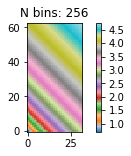

In [77]:
colors1 = getColorList("tab20",20)
print colors1[10:12]
colors1[10] = "#7E975Fff"
colors1[11] = "#D3ECA3ff"

print len(colors1),kernels.shape[0]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors1, N=256)
lib.plotter.testColorMap(cmap)
plt.rc('axes', prop_cycle=(cycler('color', colors1)))

In [78]:
kernels["colors"] = colors1[:kernels.shape[0]]
kernels["order"] = kernels.index
kernels.head()

,Name,colors,order
0,[CUDA memset],#1f77b4ff,0
1,[CUDA memcpy HtoD],#aec7e8ff,1
2,"generate_seed_pseudo(unsigned __int64, unsigne...",#ff7f0eff,2
3,"void gen_sequenced<curandStateXORWOW, float, i...",#ffbb78ff,3
4,void cudnn::detail::activation_bw_4d_kernel<fl...,#2ca02cff,4


In [79]:
def addOrderColumn(df,kernels):
    df = pd.merge(df,kernels,on="Name",how="left")
    return df

['0 [CUDA memset]' '1 [CUDA memcpy HtoD]'
 '2 generate_seed_pseudo(unsigned __int64, unsigned __int64, unsigned __int64, curandOrdering, curandStateXORWOW*, unsigned int*) [729]'
 '3 void gen_sequenced<curandStateXORWOW, float, int, __operator_&__(float curand_uniform_noargs<curandStateXORWOW>(curandStateXORWOW*, int))>(curandStateXORWOW*, float*, unsigned long, unsigned long, int) [740]'
 '4 void cudnn::detail::activation_bw_4d_kernel<float, float, int=128, int=1, int=4, cudnn::detail::relu_func<float, cudnnNanPropagation_t=1, bool=0>>(cudnnTensorStruct, float const *, float const , cudnn::detail::activation_bw_4d_kernel<float, float, int=128, int=1, int=4, cudnn::detail::relu_func<float, cudnnNanPropagation_t=1, bool=0>>, float const , cudnnTensorStruct*, float, cudnnTensorStruct*, int, cudnnTensorStruct*) [756]'
 '5 void cudnn::detail::wgrad_alg0_engine<float, int=128, int=6, int=7, int=3, int=3, int=5, bool=1, int=512>(int, int, int, float const *, int, cudnn::detail::wgrad_alg0_en

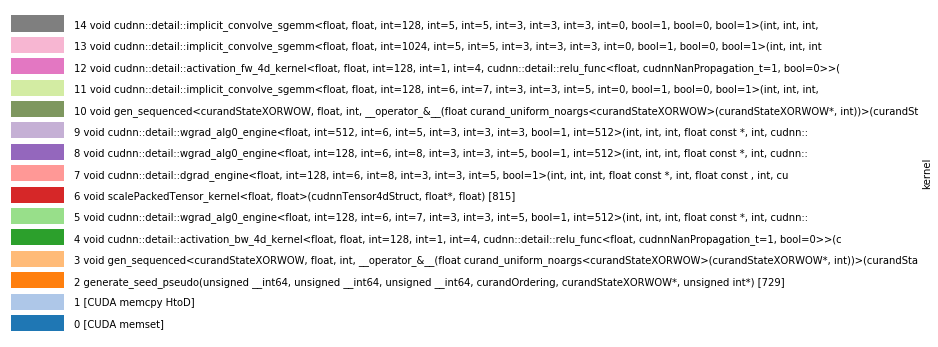

In [81]:
def plotKernelsLegend(kernels, text=False):
    dfc_ = kernels.copy()
    dfc_["y"] = 1
    size = kernels.shape[0]
    fig,ax = plt.subplots(figsize=(1,size*.4))
    ax1 = ax.twinx()
    for a in [ax,ax1]:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)
        a.spines["left"].set_visible(False)
        a.spines["bottom"].set_visible(False)
        a.get_yaxis().set_visible(False)
        a.get_xaxis().set_visible(False)
    ax1.yaxis.set_ticks_position('none')
    dfc_["kernel"] = dfc_["order"].map(str) + " " + dfc_["Name"]
    if text:
        print dfc_["kernel"].values
    dfc_["kernel"] = dfc_["kernel"].apply(lambda x: x[:150])
    dfc_.sort_values(by="order",ascending=True,inplace=True)
    dfc_.plot.barh(x="kernel",y="y",color=dfc_["colors"].values, width=.75,ax=ax1)
    ax1.legend().set_visible(False)
    plt.show()
    
plotKernelsLegend(kernels,text=True)

In [82]:
nvsc = addOrderColumn(nvprof,kernels)
nvsc["type"] = nvsc["f/b"].astype(str)+" "+nvsc["conv"].astype(str)
nvsc.head()

,Start(s),Duration(s),Grid X,Grid Y,Grid Z,Block X,Block Y,Block Z,Registers Per Thread,Static SMem(KB),...,Device,Context,Stream,Name,batch,conv,f/b,colors,order,type
0,0.923712,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Quadro P2000 (0),1,22,[CUDA memset],100,128,bwd,#1f77b4ff,0,bwd 128
1,0.924383,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Quadro P2000 (0),1,7,[CUDA memcpy HtoD],100,128,bwd,#aec7e8ff,1,bwd 128
2,0.924766,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Quadro P2000 (0),1,31,[CUDA memset],100,128,bwd,#1f77b4ff,0,bwd 128
3,0.924795,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Quadro P2000 (0),1,7,[CUDA memcpy HtoD],100,128,bwd,#aec7e8ff,1,bwd 128
4,0.925113,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Quadro P2000 (0),1,40,[CUDA memset],100,128,bwd,#1f77b4ff,0,bwd 128


### Make short kernel names

In [83]:
def shortKernels(df):
    df["kernel"] = df["Name"].str.replace("void ","")
    df["kernel"] = df["kernel"].str.replace("cudnn::detail::","")
    df["kernel"] = df["kernel"].str.replace("<"," ")
    df["kernel"] = df["kernel"].str.replace("float","f")
    df["kernel"] = df["kernel"].str.replace("int","i")
    df["kernel"] = df["kernel"].str.replace("bool","b")
    df["kernel"] = df["kernel"].str.replace("=","")
    df["kernel"] = df["kernel"].apply(lambda s: str(s).split(">")[0])
    
    df["kernel"] = df["order"].map(str) + " " + df["kernel"]
    return df
nvsc = shortKernels(nvsc)
nvsc.head()

,Start(s),Duration(s),Grid X,Grid Y,Grid Z,Block X,Block Y,Block Z,Registers Per Thread,Static SMem(KB),...,Context,Stream,Name,batch,conv,f/b,colors,order,type,kernel
0,0.923712,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,22,[CUDA memset],100,128,bwd,#1f77b4ff,0,bwd 128,0 [CUDA memset]
1,0.924383,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,7,[CUDA memcpy HtoD],100,128,bwd,#aec7e8ff,1,bwd 128,1 [CUDA memcpy HtoD]
2,0.924766,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,31,[CUDA memset],100,128,bwd,#1f77b4ff,0,bwd 128,0 [CUDA memset]
3,0.924795,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,7,[CUDA memcpy HtoD],100,128,bwd,#aec7e8ff,1,bwd 128,1 [CUDA memcpy HtoD]
4,0.925113,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,40,[CUDA memset],100,128,bwd,#1f77b4ff,0,bwd 128,0 [CUDA memset]


In [84]:
dftmp = nvsc[["Start(s)","Duration(s)","Name","batch","conv","f/b","colors","order","type","kernel"]]
dftmp[dftmp["f/b"]=="bwd"].head()
#dftmp[dftmp.isnull().any(axis=1)]

,Start(s),Duration(s),Name,batch,conv,f/b,colors,order,type,kernel
0,0.923712,0.000001,[CUDA memset],100,128,bwd,#1f77b4ff,0,bwd 128,0 [CUDA memset]
1,0.924383,0.000001,[CUDA memcpy HtoD],100,128,bwd,#aec7e8ff,1,bwd 128,1 [CUDA memcpy HtoD]
2,0.924766,0.000001,[CUDA memset],100,128,bwd,#1f77b4ff,0,bwd 128,0 [CUDA memset]
3,0.924795,0.000001,[CUDA memcpy HtoD],100,128,bwd,#aec7e8ff,1,bwd 128,1 [CUDA memcpy HtoD]
4,0.925113,0.000001,[CUDA memset],100,128,bwd,#1f77b4ff,0,bwd 128,0 [CUDA memset]


In [67]:
# Plot events series
# Groups is a pandas group object with columns "Start(s)","Duration(s)","order","colors"
# Events start times taken from "Start" column
# Event durations taken from "Duration"
# Color from "colors"
# Series names from "order"
def plotEvents(groups,ax=None):
    min_width = 0.001
    names = []
    for name,group in groups:
        names.append(name)
        y = int(group["order"].iloc[0])
        c = group["colors"].iloc[0]
        h = 0.9
        for index,row in group[["Start(s)","Duration(s)"]].iterrows():
#             print "x,w:",type(row),row
#             print type(row[1]),row[1]
            x = row["Start(s)"]
            w = max(min_width, row["Duration(s)"])
            ax.barh(y,max(min_width,w),h,x,color=c,alpha=0.5)
    majorLocator = MultipleLocator(1)
    ax.yaxis.set_major_locator(majorLocator)
    ax.set_ylim(0,None)
    ax.yaxis.grid(ls=":",linewidth=.5,alpha=.5)


In [64]:
def plotEventsTimeline(df,ax):
    dftmp = df[["Start(s)","Duration(s)","order","colors"]]
    groups = dftmp.groupby("order")
    plotEvents(groups,ax=ax)

#     print "X:",X.shape,X.shape[0],X[0]
#     print "W:",W.shape,W[0]
#     print len(names),names[0]

def plotEventsTimelineSNS(order, start, duration, colors,**kwargs):
    ax = plt.gca()
    #print order.shape,start.shape,duration.shape
    df = pd.concat([order,start,duration,colors],axis=1)
    if df.shape[0] < 1:
        return
    #print df.head()
    groups = df.groupby("order")
    plotEvents(groups,ax=ax)
    

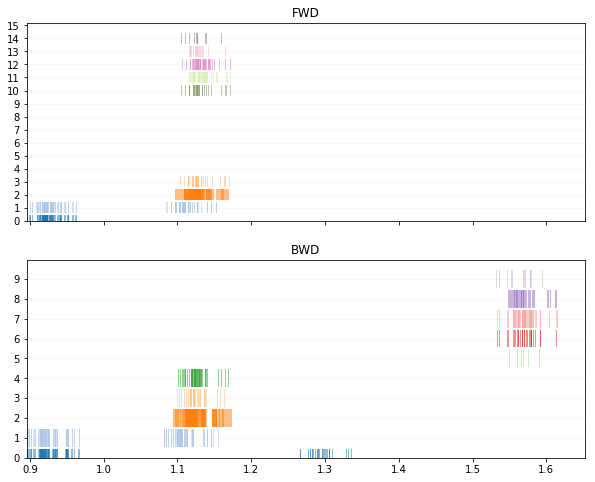

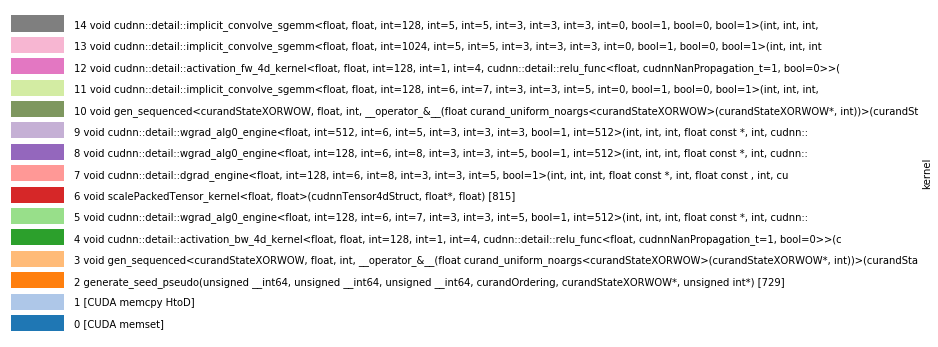

In [85]:
fig,ax = plt.subplots(2,1,figsize=(10,8),sharex=True)
# plotEventsTimeline(dftmp[dftmp["f/b"]=="fwd"],ax=ax)
# plotEventsTimeline(nvsc[(nvsc["batch"]==140) & (nvsc["type"]=="fwd 128")],ax=ax)
plotEventsTimeline(dftmp[dftmp["f/b"]=="fwd"],ax=ax[0])
plotEventsTimeline(dftmp[dftmp["f/b"]=="bwd"],ax=ax[1])
ax[0].set_title("FWD")
ax[1].set_title("BWD")
plt.show()
plotKernelsLegend(kernels)

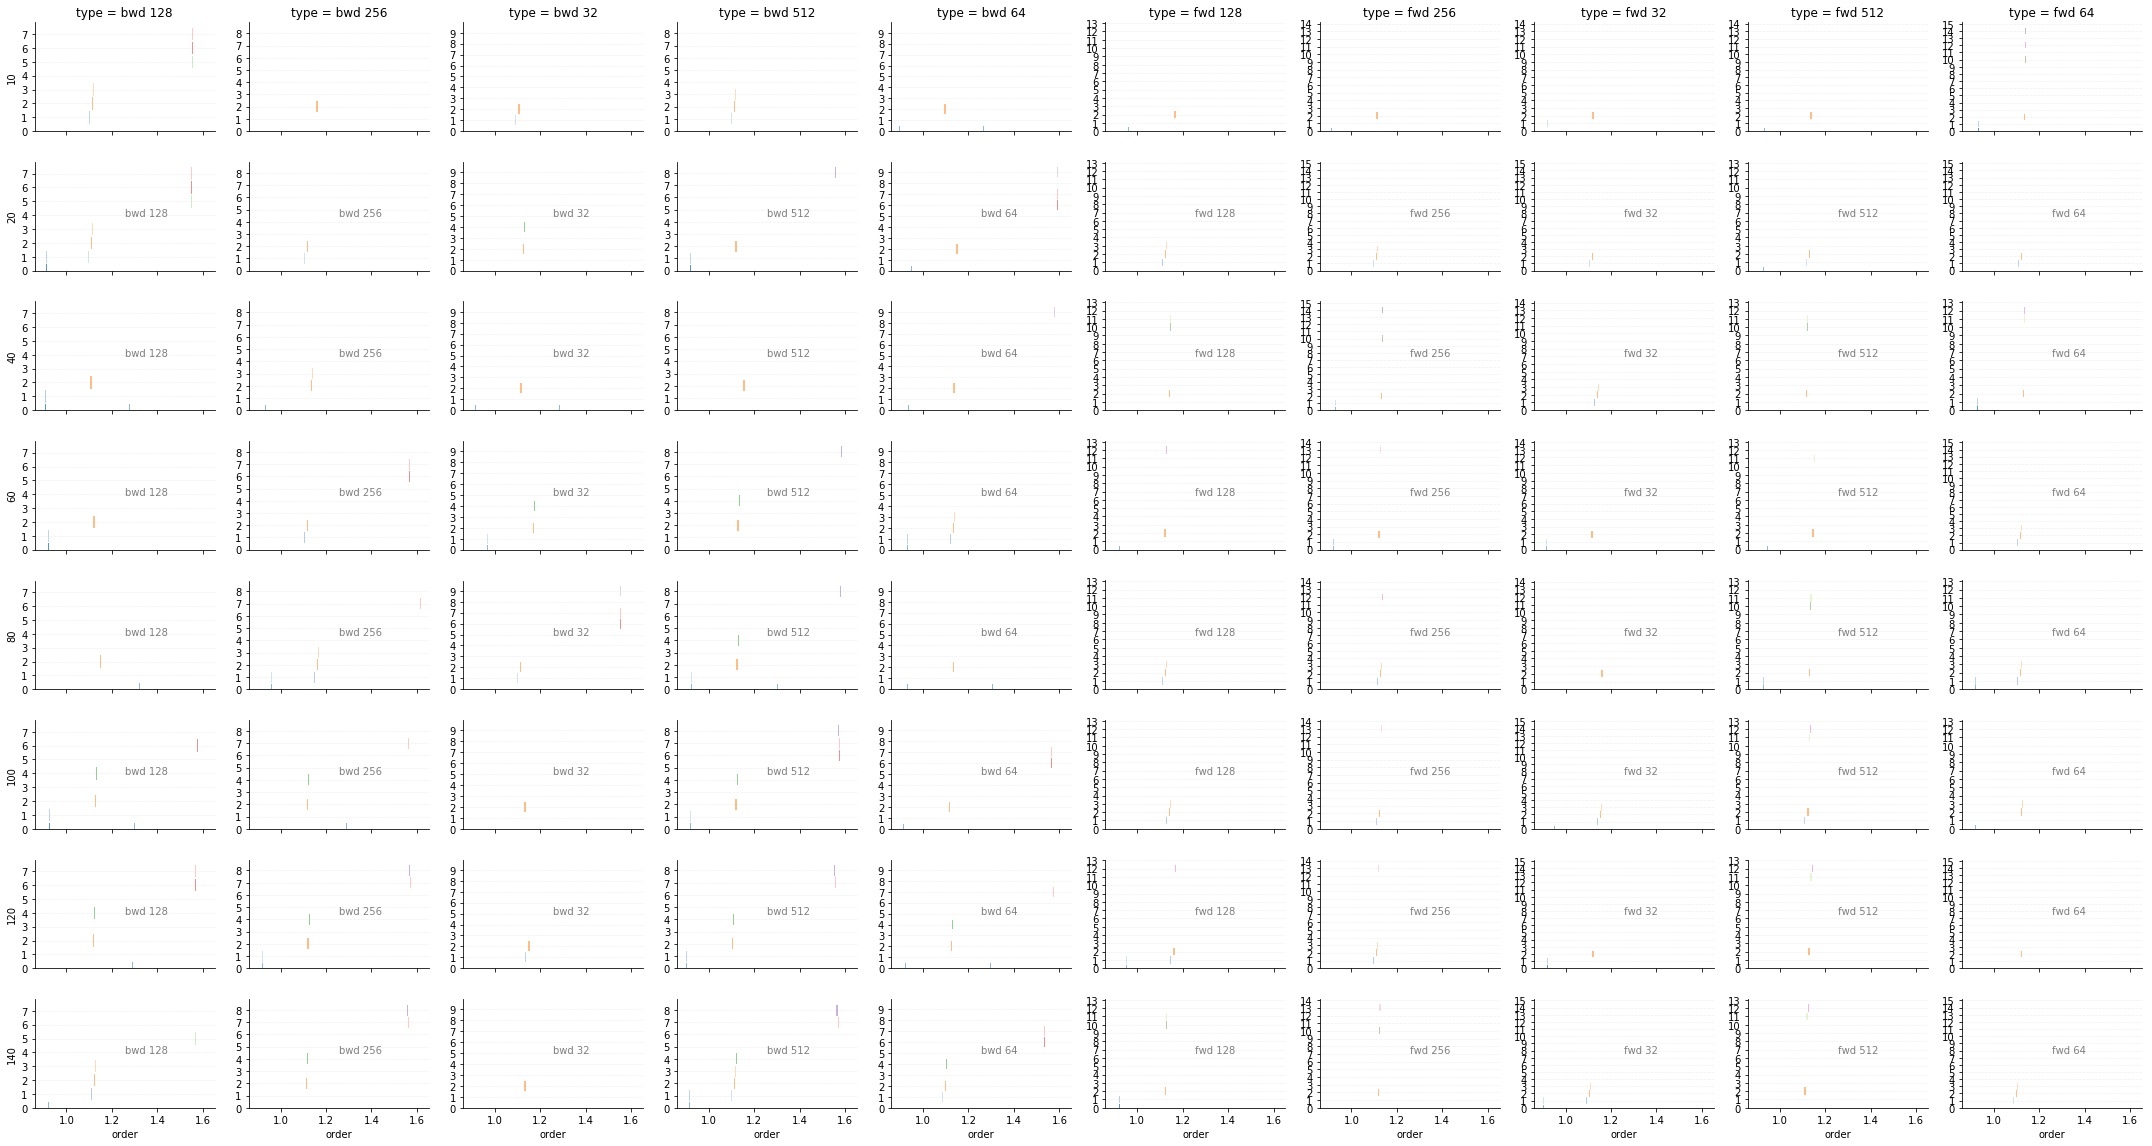

In [86]:
fg = sns.FacetGrid(nvsc, row="batch", col="type",size=2,aspect=1.5,sharey=False)
fg.map(plotEventsTimelineSNS,"order","Start(s)","Duration(s)","colors")
# for (i,j,k), data in fg.facet_data():
#     ax = fg.facet_axis(i, j)
#     plotEventsTimeline(data,ax)
for i, axes_row in enumerate(fg.axes):
    for j, axes_col in enumerate(axes_row):
        row, col = axes_col.get_title().split('|')

        if i == 0:
            axes_col.set_title(col.strip())
        else:
            axes_col.set_title('')
            axes_col.text(.5,.5,col.split("=")[1].strip(),alpha=.5,fontsize=10,transform=axes_col.transAxes)

        if j == 0:
            row_title = row.split("=")[1].strip()
            axes_col.set_ylabel(row_title)
                   